# Introduction

Healthcare inequity is a global challenge.

Addressing this challenge has an extensive positive impact on women’s health, which is key for societies and economies to thrive. 

This datathon was designed to help discover whether disparate treatments exist and to understand the drivers of those biases, such as demographic and societal factors.


In [2]:
# Import Libraries

import numpy as np # linear algebra
import pandas as pd # for data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for data visulaization
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import catboost
import xgboost
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [4]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


# Load datasets

The dataset for this challenge contained health related information of patients who were diagnosed with metastatic triple negative breast cancers in the US. 

The data set was also enriched with the US Zip Codes Database which were built from the ground up using authoritative sources including the U.S. Postal Service™, U.S. Census Bureau, National Weather Service, American Community Survey, and the IRS, to obtain additional social economic information based on the locations of the patients.


The dataset was then further enriched, also using zip code level, with toxicology data from NASA/Columbia University, to explore the relations between health outcomes and toxic air conditions.


In [6]:
# Load Competiton Datasets and drop breast_cancer_diagnosis_code
df = pd.read_csv("./dataset/training.csv")
tdf = pd.read_csv("./dataset/test.csv")
ss = pd.read_csv("./dataset/sample_submission.csv")

In [8]:
df['bmi'].isnull().sum()

8965

In [10]:
df.describe()

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
count,12906.000000,12906.000000,12906.000000,3941.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,...,12905.000000,12902.000000,12902.000000,12905.000000,12905.000000,12905.000000,12877.000000,12877.000000,12877.000000,12906.000000
mean,547381.196033,573.754300,59.183326,28.984539,20744.441237,1581.950419,40.502259,11.122784,12.945265,13.290376,...,13.335299,13.406950,4.474956,27.978387,8.575284,7.083376,39.822352,7.475221,16.098988,0.624516
std,260404.959974,275.447534,13.335216,5.696906,13886.903756,2966.305306,4.036963,1.512376,1.923974,3.354103,...,3.690949,5.222495,4.837085,5.083939,4.203482,3.109022,3.559492,1.516499,5.842501,0.484266
min,100063.000000,101.000000,18.000000,14.000000,635.545455,0.916667,20.600000,0.000000,6.314286,5.925000,...,4.600000,3.433333,0.000000,12.460784,2.440000,1.200000,30.939316,2.636008,2.760371,0.000000
25%,321517.000000,331.000000,50.000000,24.660000,9463.896552,171.857143,37.129825,10.160000,11.741176,11.013415,...,10.270492,9.663333,0.994444,24.933333,5.618750,4.929688,37.698880,6.651215,11.280694,0.000000
50%,543522.000000,554.000000,59.000000,28.190000,19154.190480,700.337500,40.639344,11.039216,12.923944,12.538095,...,12.884000,12.177778,2.747222,27.788235,7.465714,6.847059,39.108249,7.686577,15.589148,1.000000
75%,772671.750000,846.000000,67.000000,32.920000,30021.278690,1666.515385,42.934783,12.190000,14.019767,14.971053,...,15.555405,16.635556,5.976000,30.709375,10.617442,8.620000,41.136513,8.276922,20.801880,1.000000
max,999896.000000,999.000000,91.000000,85.000000,71374.131580,21172.000000,54.570000,17.675000,35.300000,62.100000,...,35.155556,38.347826,26.755000,48.020000,27.566102,25.200000,52.237210,11.169408,31.504775,1.000000


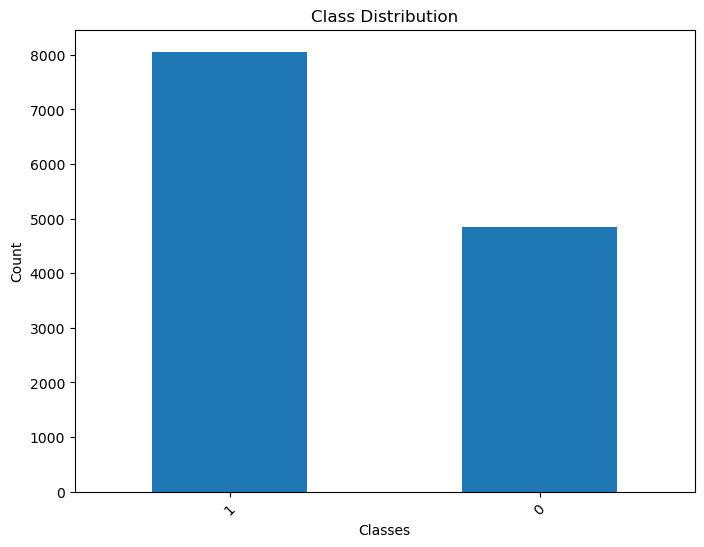

In [12]:
target = "DiagPeriodL90D"

# Count the occurrences of each class
class_counts = df[target].value_counts()

# Plot the class distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [13]:
# 결측치 개수와 비율을 정리한 테이블 만들기
missing_df = pd.DataFrame({
    'Missing Values': df.isnull().sum(),
    'Missing Ratio (%)': (df.isnull().sum() / len(df)) * 100
})

# 결측치가 아예 없는 컬럼은 제외하고 보기
missing_df = missing_df[missing_df['Missing Values'] > 0]

# 결측치 많은 순으로 정렬
missing_df = missing_df.sort_values(by='Missing Values', ascending=False)

# 출력
display(missing_df)

,Missing Values,Missing Ratio (%)
metastatic_first_novel_treatment,12882,99.814040
metastatic_first_novel_treatment_type,12882,99.814040
bmi,8965,69.463815
patient_race,6385,49.473113
payer_type,1803,13.970246
...,...,...
age_10_to_19,1,0.007748
education_less_highschool,1,0.007748
education_highschool,1,0.007748
education_some_college,1,0.007748


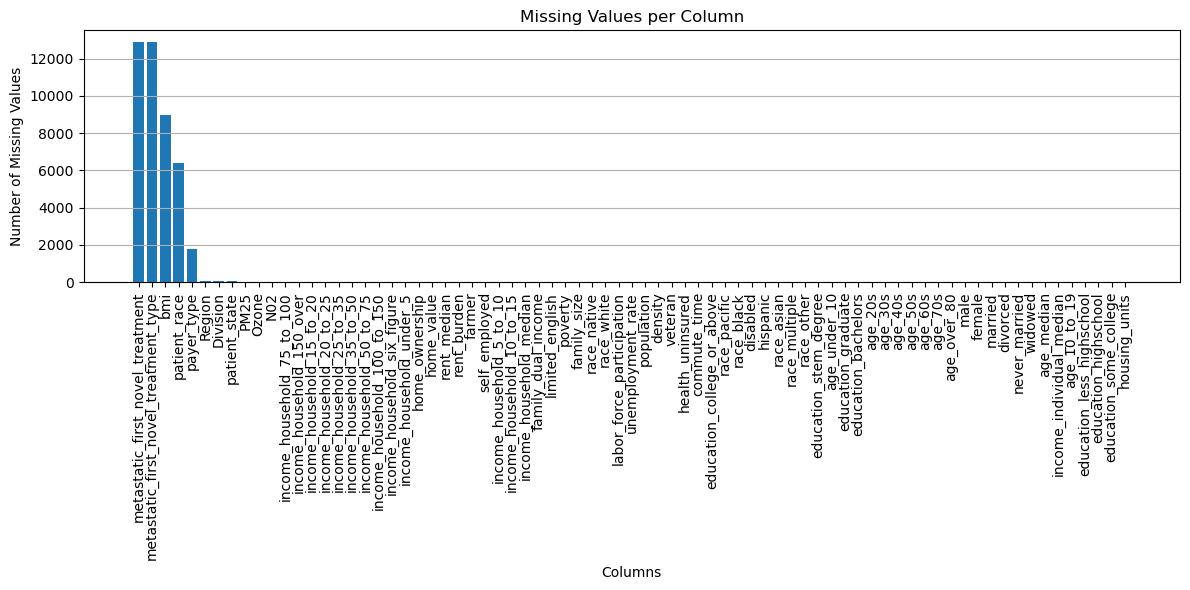

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# 결측치 개수 계산
missing_df = df.isnull().sum()

# 결측치가 있는 컬럼만 필터링
missing_df = missing_df[missing_df > 0]

# 결측치 개수 많은 순 정렬
missing_df = missing_df.sort_values(ascending=False)

# 시각화
plt.figure(figsize=(12, 6))
plt.bar(missing_df.index, missing_df.values)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values per Column')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [17]:
df.columns

Index(['patient_id', 'patient_race', 'payer_type', 'patient_state',
       'patient_zip3', 'patient_age', 'patient_gender', 'bmi',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division',
       'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19',
       'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s',
       'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_median', 'income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'in

In [20]:
df['breast_cancer_diagnosis_code'].value_counts()

breast_cancer_diagnosis_code
1749      1982
C50911    1797
C50912    1712
C50919    1467
C50411     978
C50412     877
C50811     491
C50812     419
1744       389
1748       307
C50212     293
C50211     276
C50511     213
C50112     209
C50111     208
C50512     176
C50312     159
C50311     138
C50011     108
C50012     105
1742        98
1741        88
1745        71
C50819      54
C50419      48
C5091       37
1743        34
C50612      29
C50611      25
C50319      16
C50019      13
1746        12
C50219      11
C50119      11
C5041        9
19881        9
C5081        8
C50519       8
C5021        3
C509         3
C50929       3
C50619       3
C5011        2
C50021       1
C5031        1
C5051        1
C50          1
1759         1
C5001        1
C50421       1
Name: count, dtype: int64

In [22]:
df['breast_cancer_diagnosis_desc'].value_counts()

breast_cancer_diagnosis_desc
Malignant neoplasm of breast (female), unspecified                  1982
Malignant neoplasm of unsp site of right female breast              1797
Malignant neoplasm of unspecified site of left female breast        1712
Malignant neoplasm of unsp site of unspecified female breast        1467
Malig neoplm of upper-outer quadrant of right female breast          978
Malig neoplasm of upper-outer quadrant of left female breast         877
Malignant neoplasm of ovrlp sites of right female breast             491
Malignant neoplasm of ovrlp sites of left female breast              419
Malignant neoplasm of upper-outer quadrant of female breast          389
Malignant neoplasm of other specified sites of female breast         307
Malig neoplasm of upper-inner quadrant of left female breast         293
Malig neoplm of upper-inner quadrant of right female breast          276
Malig neoplm of lower-outer quadrant of right female breast          213
Malignant neoplasm of 

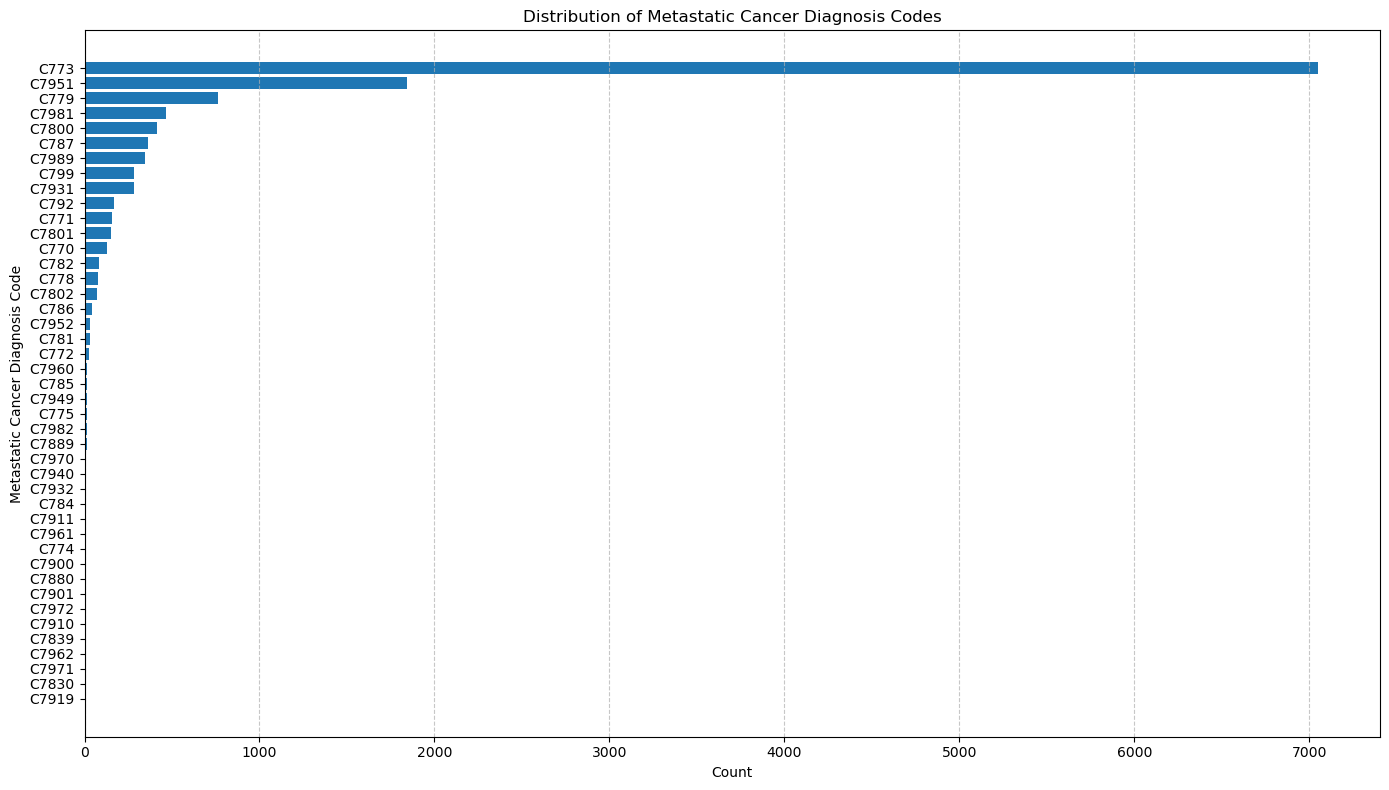

In [24]:
df_metastatic_cancer_diagnosis_code_counts = df['metastatic_cancer_diagnosis_code'].value_counts()

# 1. metastatic_cancer_diagnosis_code별 count 구하기
df_metastatic_cancer_diagnosis_code_counts = df['metastatic_cancer_diagnosis_code'].value_counts()

# 2. (이미 value_counts()가 내림차순이지만) 확실하게 정렬
df_counts = df_metastatic_cancer_diagnosis_code_counts.sort_values(ascending=False)

# 3. 시각화
plt.figure(figsize=(14, 8))
plt.barh(df_counts.index, df_counts.values)  # <-- index와 values로 접근
plt.xlabel('Count')
plt.ylabel('Metastatic Cancer Diagnosis Code')
plt.title('Distribution of Metastatic Cancer Diagnosis Codes')
plt.gca().invert_yaxis()  # 가장 많은 값이 위로
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
df[df['metastatic_first_novel_treatment'].notna()]['metastatic_first_novel_treatment'].value_counts()

metastatic_first_novel_treatment
PEMBROLIZUMAB    13
OLAPARIB         11
Name: count, dtype: int64

In [28]:
df[df['metastatic_first_novel_treatment_type'].notna()]['metastatic_first_novel_treatment_type'].value_counts()

metastatic_first_novel_treatment_type
Antineoplastics    24
Name: count, dtype: int64

- # Data Cleaning

Zip code level metadata were dropped except product of N02,PM25 & Ozone

Data set contained missing values which we left unhandled


In [31]:
#  Find Product of Pollutants
df["N02xOzonexPM25"]=df["N02"]*df["Ozone"]*df["PM25"]
tdf["N02xOzonexPM25"]=tdf["N02"]*tdf["Ozone"]*tdf["PM25"]

In [33]:
# Drop some features
# List of columns to iterate over
columns_to_iterate = [col for col in df.columns if col not in ["patient_zip3", "N02xOzonexPM25"]]

# Iterate over each column
for col in columns_to_iterate:
    # Your code to operate on each column goes here
    df["check"]=df.groupby(["patient_zip3","N02xOzonexPM25"])[col].transform("nunique")
    if df["check"].max()==1:
        print("dropped ",col)
        df=df.drop(col,axis=1)
        tdf=tdf.drop(col,axis=1)
df=df.drop("check",axis=1)

dropped  patient_gender
dropped  metastatic_first_novel_treatment
dropped  metastatic_first_novel_treatment_type
dropped  population
dropped  density
dropped  age_median
dropped  age_under_10
dropped  age_10_to_19
dropped  age_20s
dropped  age_30s
dropped  age_40s
dropped  age_50s
dropped  age_60s
dropped  age_70s
dropped  age_over_80
dropped  male
dropped  female
dropped  married
dropped  divorced
dropped  never_married
dropped  widowed
dropped  family_size
dropped  family_dual_income
dropped  income_household_median
dropped  income_household_under_5
dropped  income_household_5_to_10
dropped  income_household_10_to_15
dropped  income_household_15_to_20
dropped  income_household_20_to_25
dropped  income_household_25_to_35
dropped  income_household_35_to_50
dropped  income_household_50_to_75
dropped  income_household_75_to_100
dropped  income_household_100_to_150
dropped  income_household_150_over
dropped  income_household_six_figure
dropped  income_individual_median
dropped  home_owner

In [34]:
# define target variable and categorical features
cat_cols = list(tdf.columns[tdf.dtypes=="object"])
cols = [col for col in tdf.columns if col not in ["patient_id"]]
tdf[target] = np.nan

In [37]:
# concatenate train and test set
df = pd.concat([df,tdf[df.columns]],axis=0)

- # Feature Engineering

We then combined various pollutants into a single feature.

Our goal was to capture the overall environmental impact in a more digestible form for our models. Additionally, we introduced flags for critical variables:

A flag for metastatic_cancer_diagnosis_code with a length of 4 to identify specific diagnosis codes of interest.

A flag for breast_cancer_diagnosis_desc containing the term "female". 

We applied one-hot encoding to a carefully selected set of features, including payer_type, patient_race, and breast_cancer_diagnosis_desc, among others

In [40]:
df["clust"]=(df.metastatic_cancer_diagnosis_code.str.len()==4).astype("int")
df["is_female"] = df.breast_cancer_diagnosis_desc.str.contains("female").astype("int")
df["is_female"].value_counts()

is_female
1    18665
0       33
Name: count, dtype: int64

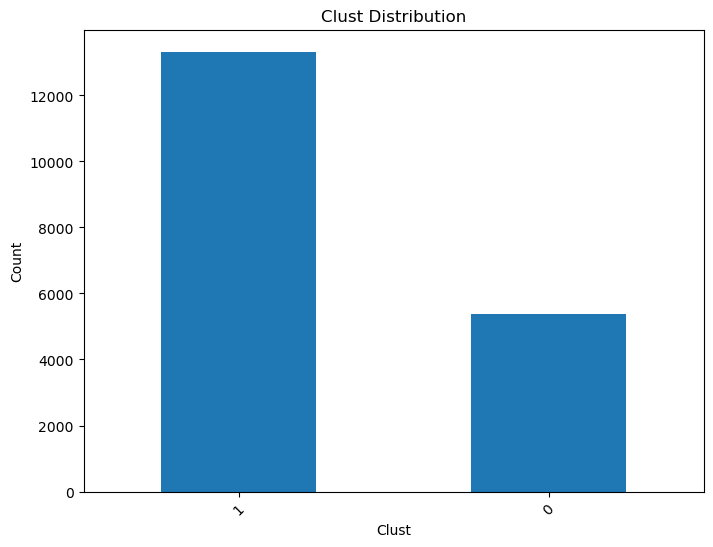

In [42]:
# Count the occurrences of each class
clust_counts = df["clust"].value_counts()

# Plot the clust distribution
plt.figure(figsize=(8, 6))
clust_counts.plot(kind='bar')
plt.title('Clust Distribution')
plt.xlabel('Clust')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [44]:
# do one-hot encoding for some features
age_cols = list(df.filter(regex="age").columns)
cols = list(set(cols)-set(age_cols))
income_cols = list(df.filter(regex="income").columns)
cols = list(set(cols)-set(income_cols))
cols = list(set(cols)-{"breast_cancer_diagnosis_code","N02xOzonexPM25","bmi"})
df=pd.get_dummies(df,columns=cols,dtype="int",drop_first=True)
cols

['Region',
 'patient_race',
 'breast_cancer_diagnosis_desc',
 'payer_type',
 'patient_state',
 'metastatic_cancer_diagnosis_code',
 'Division',
 'patient_zip3']

In [46]:
# do label encoding for categorical columns
le=LabelEncoder()
for col in cat_cols:
    try:
        df[col]=le.fit_transform(df[col]).astype("int")
        print(col)
    except:
        continue

breast_cancer_diagnosis_code


In [48]:
tdf=df[df[target].isna()]
df=df[df[target].notna()]
len(df),len(tdf)

(12906, 5792)

- # Modelling

Our model architecture consisted of base models and a meta-model:

Base Models: We utilized two CatBoost models and one XGBoost model.

These models were chosen for their robust handling of categorical features and their ability to handle the missing data in our dataset.


Meta-Model: A Logistic Regression model served as our meta-model.

In [51]:
modela = CatBoostClassifier(iterations=500, silent=True, learning_rate=0.05, depth=10, eval_metric='AUC', random_seed=42)
modelb = CatBoostClassifier(iterations=500, silent=True, learning_rate=0.05, depth=10, eval_metric='AUC', random_seed=42)
model2a = XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.9
)

In [53]:
# finalize features for training
drop_cols=["patient_id",target,"patient_zip3","patient_state"]
cols=list(set(df.columns)-set(drop_cols))

In [55]:
# Define the number of folds
num_folds = 10
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [57]:
# use stacking method, define meta model
from sklearn.linear_model import LogisticRegression
meta_model = LogisticRegression()
meta_features=['pred1b','pred2','pred1']

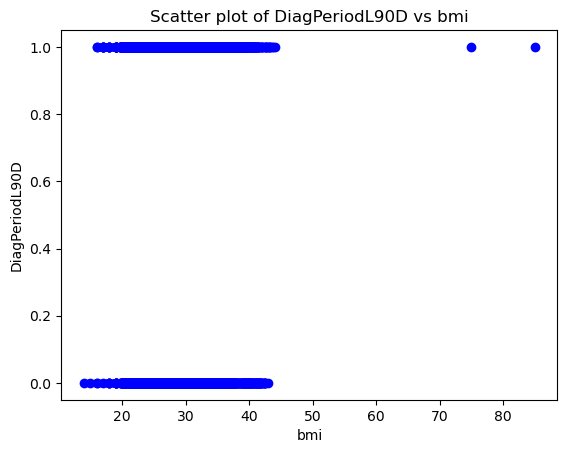

In [59]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting
plt.scatter(df['bmi'], df[target], color='blue')
plt.xlabel('bmi')
plt.ylabel(target)
plt.title(f'Scatter plot of {target} vs bmi')
plt.savefig('bmi.png')
plt.show()


In [ ]:
# Initialize empty dataframe to store predictions from all folds
predictions_from_folds=pd.DataFrame()
# Iterate over folds
for fold, (train_index, val_index) in enumerate(kf.split(df, df[target])):
    dfx, efx = df.iloc[train_index], df.iloc[val_index]
    # train and make predictions on train set
    efx["pred1"] = modela.fit(dfx[cols].values, dfx[target]).predict_proba(efx[cols].values)[:,1]
    efx["pred2"] = modelb.fit(dfx[cols].values, dfx[target]).predict_proba(efx[cols].values)[:,1]
    efx["pred1b"] = model2a.fit(dfx[cols].values, dfx[target]).predict_proba(efx[cols].values)[:,1]  
    # make predictions on test set
    tdf["pred1"] = modela.predict_proba(tdf[cols].values)[:,1]
    tdf["pred2"] = modelb.predict_proba(tdf[cols].values)[:,1]
    tdf["pred1b"] = model2a.predict_proba(tdf[cols].values)[:,1]
    # train meta-models and make final predictions 
    tdf["pred"] = meta_model.fit(efx[meta_features], efx[target]).predict_proba(tdf[meta_features])[:, 1]
    predictions_from_folds=pd.concat([predictions_from_folds,tdf],axis=0)

In [ ]:
# feature importance

feature_imp = pd.DataFrame(sorted(zip(modela.feature_importances_,cols)), columns=['Value','Feature'])
feature_imp=feature_imp.sort_values("Value",ascending=False)
feature_imp=feature_imp.head(10)
feature_imp["Feature"]=feature_imp["Feature"]
plt.figure(figsize=(5, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Features Importance')
plt.tight_layout()
plt.savefig('cb_importances.png')
plt.show()

- # Submission

In [ ]:
# blend predictions from all folds
final_predictions=predictions_from_folds.groupby("patient_id").mean().reset_index()
final_predictions[target]=final_predictions["pred"].values
final_predictions[ss.columns].to_csv("final_predictions.csv",index=None)